In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from pathlib import Path
import tensorflow as tf
import torch
import numpy as np
import cv2
from imutils import perspective
import numpy as np
from skimage.filters import threshold_local
import imutils
from keras.models import load_model
import keras
import matplotlib.pyplot as plt
from PIL import Image, ImageFilter
from google.colab.patches import cv2_imshow

In [ ]:
best_path = "/content/drive/MyDrive/Machine_Learning/best.pt"
model_detect_frame = torch.hub.load('ultralytics/yolov5', 'custom', path=best_path, force_reload=True)
model = load_model("/content/drive/MyDrive/Machine_Learning/Model_KyTu.h5", compile=False)

/usr/local/lib/python3.10/dist-packages/torch/hub.py:294: UserWarning: You are about to download and run code from an untrusted repository. In a future release, this won't be allowed. To add the repository to your trusted list, change the command to {calling_fn}(..., trust_repo=False) and a command prompt will appear asking for an explicit confirmation of trust, or load(..., trust_repo=True), which will assume that the prompt is to be answered with 'yes'. You can also use load(..., trust_repo='check') which will only prompt for confirmation if the repo is not already trusted. This will eventually be the default behaviour
  warnings.warn(
Downloading: "https://github.com/ultralytics/yolov5/zipball/master" to /root/.cache/torch/hub/master.zip


requirements: Ultralytics requirements ['gitpython>=3.1.30', 'Pillow>=10.0.1'] not found, attempting AutoUpdate...
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.6/190.6 kB 2.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 24.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 177.2 MB/s eta 0:00:00
  Attempting uninstall: Pillow
    Found existing installation: Pillow 9.4.0
    Uninstalling Pillow-9.4.0:
      Successfully uninstalled Pillow-9.4.0

requirements: AutoUpdate success ✅ 9.1s, installed 2 packages: ['gitpython>=3.1.30', 'Pillow>=10.0.1']
requirements: ⚠️ Restart runtime or rerun command for updates to take effect



YOLOv5 🚀 2023-12-17 Python-3.10.12 torch-2.1.0+cu121 CPU

Fusing layers... 
BienSo summary: 182 layers, 7246518 parameters, 0 gradients
Adding AutoShape... 


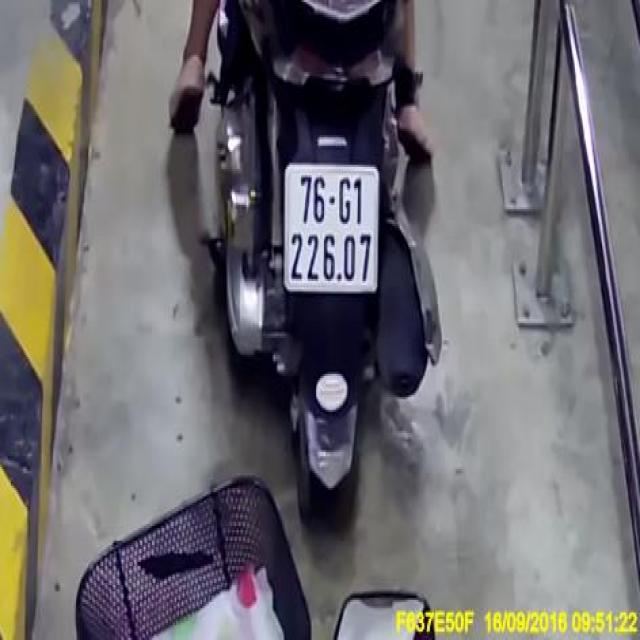

In [ ]:
img=cv2.imread('/content/drive/MyDrive/Machine_Learning/Data/BienSo/test/images/0251_07030_b_jpg.rf.85224e25db33dd97ced706b84d26a392.jpg')
cv2_imshow(img)

In [ ]:
results = model_detect_frame(img)
df = results.pandas().xyxy[0]
for obj in df.iloc:
    xmin = float(obj['xmin'])
    xmax = float(obj['xmax'])
    ymin = float(obj['ymin'])
    ymax = float(obj['ymax'])
coord = np.array([[xmin, ymin], [xmax, ymin], [xmax, ymax], [xmin, ymax]])
LpRegion = perspective.four_point_transform(img, coord)

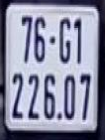

In [ ]:
cv2_imshow(LpRegion)

In [ ]:
Hang = cv2.resize(LpRegion, (300, 300),fx=0,fy=0, interpolation = cv2.INTER_CUBIC)
Tren=Hang[0:160, 0:300]
Duoi=Hang[140:300, 0:300]

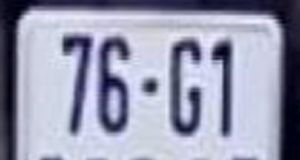

In [ ]:
cv2_imshow(Tren)

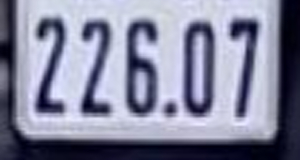

In [ ]:
cv2_imshow(Duoi)

In [ ]:
def find_contours(dimensions, img) :
    cntrs, _ = cv2.findContours(img.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    lower_width = dimensions[0]
    upper_width = dimensions[1]
    lower_height = dimensions[2]
    upper_height = dimensions[3]
    cntrs = sorted(cntrs, key=cv2.contourArea, reverse=True)[:15]
    ii = cv2.imread('contours.jpg')
    x_cntr_list = []
    target_contours = []
    img_res = []
    for cntr in cntrs :
        intX, intY, intWidth, intHeight = cv2.boundingRect(cntr)
        if intWidth > lower_width and intWidth < upper_width and intHeight > lower_height and intHeight < upper_height:
            x_cntr_list.append(intX)
            char_copy = np.zeros((44,24))
            char = img[intY:intY+intHeight, intX:intX+intWidth]
            char = cv2.resize(char, (20, 40))
            cv2.rectangle(ii, (intX,intY), (intWidth+intX, intY+intHeight), (50,21,200), 2)
            plt.imshow(ii, cmap='gray')
            char = cv2.subtract(255, char)
            char_copy[2:42, 2:22] = char
            char_copy[0:2, :] = 0
            char_copy[:, 0:2] = 0
            char_copy[42:44, :] = 0
            char_copy[:, 22:24] = 0
            img_res.append(char_copy)
    plt.show()
    indices = sorted(range(len(x_cntr_list)), key=lambda k: x_cntr_list[k])
    img_res_copy = []
    for idx in indices:
        img_res_copy.append(img_res[idx])
    img_res = np.array(img_res_copy)
    return img_res

In [ ]:
def segment_characters(image):
    img_lp = cv2.resize(image, (300, 95))
    img_gray_lp = cv2.cvtColor(img_lp, cv2.COLOR_BGR2GRAY)
    _, img_binary_lp = cv2.threshold(img_gray_lp, 200, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    img_binary_lp = cv2.erode(img_binary_lp, (3,3))
    img_binary_lp = cv2.dilate(img_binary_lp, (3,3))
    LP_WIDTH = img_binary_lp.shape[0]
    LP_HEIGHT = img_binary_lp.shape[1]
    img_binary_lp[0:10,:] = 255
    img_binary_lp[:,0:30] = 255
    img_binary_lp[93:95,:] = 255
    img_binary_lp[:,265:333] = 255
    dimensions = [LP_WIDTH/6,
                       LP_WIDTH/2,
                       LP_HEIGHT/10,
                       2*LP_HEIGHT/3]
    plt.imshow(img_binary_lp, cmap='gray')
    plt.show()
    cv2.imwrite('contours.jpg',img_binary_lp)
    char_list = find_contours(dimensions, img_binary_lp)
    return char_list

In [ ]:
%matplotlib inline

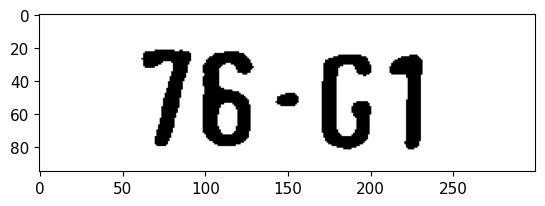

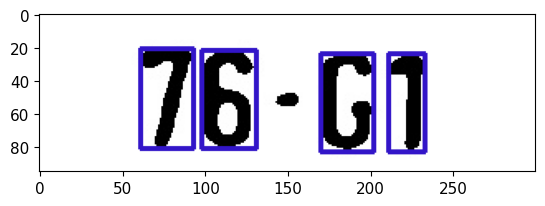

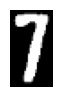

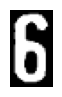

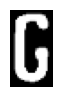

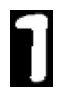

In [ ]:
char1 = segment_characters(Tren)
for i in range(4):
    plt.subplot(1, 10, i+1)
    plt.imshow(char1[i], cmap='gray')
    plt.axis('off')
    plt.show()

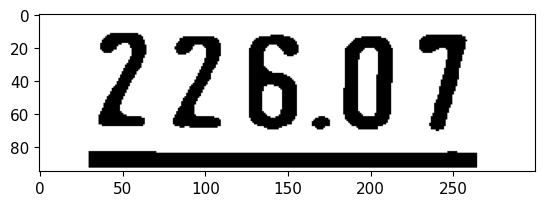

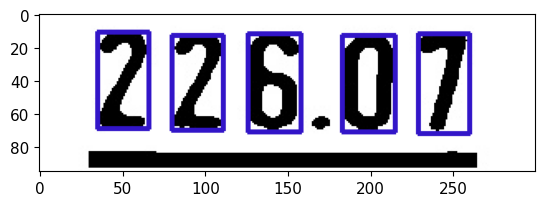

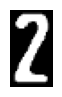

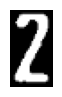

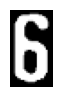

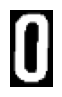

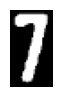

In [ ]:
char2 = segment_characters(Duoi)
for j in range(5):
    plt.subplot(1, 10, j+1)
    plt.imshow(char2[j], cmap='gray')
    plt.axis('off')
    plt.show()

In [ ]:
def fix_dimension(img):
    new_img = np.zeros((28,28,3))
    for i in range(3):
        new_img[:,:,i] = img
    return new_img

def show_results(char):
    dic = {}
    characters = '0123456789ABCDEFGHKLMNPRSTUVXYZ'
    for i,c in enumerate(characters):
        dic[i] = c

    output = []
    for i,ch in enumerate(char):
        img_ = cv2.resize(ch, (28,28), interpolation=cv2.INTER_AREA)
        img = fix_dimension(img_)
        img = img.reshape(1,28,28,3)
        y_ = model.predict(img)
        y_ = np.argmax(y_, axis=1)
        x=y_[0]
        print(y_)
        output.append(characters[x])

    plate_number = ''.join(output)

    return plate_number

print(show_results(char1))
print(show_results(char2))

1/1 [==============================] - 0s 56ms/step
[7]
1/1 [==============================] - 0s 62ms/step
[6]
1/1 [==============================] - 0s 58ms/step
[16]
1/1 [==============================] - 0s 58ms/step
[1]
76G1
1/1 [==============================] - 0s 55ms/step
[2]
1/1 [==============================] - 0s 54ms/step
[2]
1/1 [==============================] - 0s 57ms/step
[6]
1/1 [==============================] - 0s 32ms/step
[0]
1/1 [==============================] - 0s 37ms/step
[7]
22607


1/1 [==============================] - 0s 35ms/step
[7]
1/1 [==============================] - 0s 34ms/step
[6]
1/1 [==============================] - 0s 35ms/step
[16]
1/1 [==============================] - 0s 36ms/step
[1]
1/1 [==============================] - 0s 36ms/step
[7]
1/1 [==============================] - 0s 33ms/step
[6]
1/1 [==============================] - 0s 34ms/step
[16]
1/1 [==============================] - 0s 38ms/step
[1]
1/1 [==============================] - 0s 38ms/step
[7]
1/1 [==============================] - 0s 36ms/step
[6]
1/1 [==============================] - 0s 35ms/step
[16]
1/1 [==============================] - 0s 33ms/step
[1]
1/1 [==============================] - 0s 34ms/step
[7]
1/1 [==============================] - 0s 36ms/step
[6]
1/1 [==============================] - 0s 36ms/step
[16]
1/1 [==============================] - 0s 34ms/step
[1]


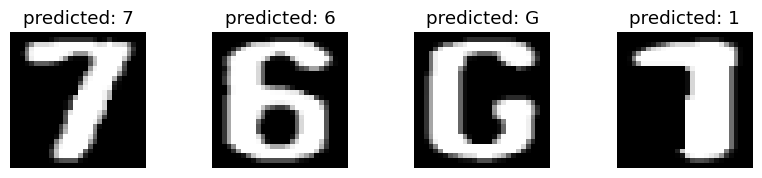

In [ ]:
# Segmented characters and their predicted value.
plt.figure(figsize=(10,6))
for i,ch in enumerate(char1):
    img = cv2.resize(ch, (28,28), interpolation=cv2.INTER_AREA)
    plt.subplot(3,4,i+1)
    plt.imshow(img,cmap='gray')
    plt.title(f'predicted: {show_results(char1)[i]}')
    plt.axis('off')
plt.show()

1/1 [==============================] - 0s 35ms/step
[2]
1/1 [==============================] - 0s 33ms/step
[2]
1/1 [==============================] - 0s 38ms/step
[6]
1/1 [==============================] - 0s 35ms/step
[0]
1/1 [==============================] - 0s 32ms/step
[7]
1/1 [==============================] - 0s 34ms/step
[2]
1/1 [==============================] - 0s 37ms/step
[2]
1/1 [==============================] - 0s 37ms/step
[6]
1/1 [==============================] - 0s 37ms/step
[0]
1/1 [==============================] - 0s 60ms/step
[7]
1/1 [==============================] - 0s 55ms/step
[2]
1/1 [==============================] - 0s 55ms/step
[2]
1/1 [==============================] - 0s 58ms/step
[6]
1/1 [==============================] - 0s 59ms/step
[0]
1/1 [==============================] - 0s 58ms/step
[7]
1/1 [==============================] - 0s 66ms/step
[2]
1/1 [==============================] - 0s 57ms/step
[2]
1/1 [==============================] - 0s 55ms/s

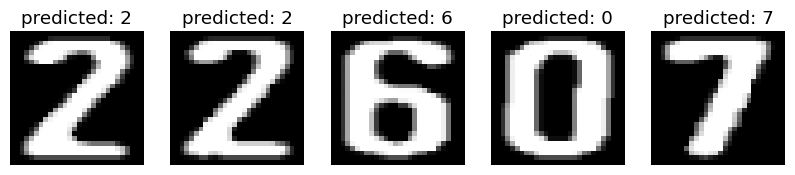

In [ ]:
# Segmented characters and their predicted value.
plt.figure(figsize=(10,6))
for i,ch in enumerate(char2):
    img = cv2.resize(ch, (28,28), interpolation=cv2.INTER_AREA)
    plt.subplot(3,5,i+1)
    plt.imshow(img,cmap='gray')
    plt.title(f'predicted: {show_results(char2)[i]}')
    plt.axis('off')
plt.show()